In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                      | 0/60000 [00:00<?, ?it/s]

 12%|██████████████▉                                                                                                         | 7461/60000 [00:00<00:00, 74599.76it/s]

 25%|█████████████████████████████▌                                                                                         | 14921/60000 [00:00<00:00, 69886.92it/s]

 37%|███████████████████████████████████████████▍                                                                           | 21930/60000 [00:00<00:00, 69652.07it/s]

 49%|██████████████████████████████████████████████████████████▍                                                            | 29488/60000 [00:00<00:00, 71933.85it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                              | 36694/60000 [00:00<00:00, 71594.08it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▌                               | 44164/60000 [00:00<00:00, 72633.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 51659/60000 [00:00<00:00, 73382.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 59003/60000 [00:00<00:00, 71278.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71578.82it/s]

  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 7150/10000 [00:00<00:00, 71495.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71727.18it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 mf83m6il


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/184 [00:00<?, ?it/s]

  1%|▋                                                                                                                               | 1/184 [00:00<01:49,  1.68it/s]

  2%|██                                                                                                                              | 3/184 [00:00<00:35,  5.15it/s]

  3%|███▍                                                                                                                            | 5/184 [00:00<00:21,  8.22it/s]

  4%|████▊                                                                                                                           | 7/184 [00:00<00:16, 10.81it/s]

  5%|██████▎                                                                                                                         | 9/184 [00:01<00:13, 12.88it/s]

  6%|███████▌                                                                                                                       | 11/184 [00:01<00:11, 14.45it/s]

  7%|████████▉                                                                                                                      | 13/184 [00:01<00:10, 15.64it/s]

  8%|██████████▎                                                                                                                    | 15/184 [00:01<00:10, 16.51it/s]

  9%|███████████▋                                                                                                                   | 17/184 [00:01<00:09, 17.14it/s]

 10%|█████████████                                                                                                                  | 19/184 [00:01<00:09, 17.60it/s]

 11%|██████████████▍                                                                                                                | 21/184 [00:01<00:09, 17.92it/s]

 12%|███████████████▉                                                                                                               | 23/184 [00:01<00:08, 18.14it/s]

 14%|█████████████████▎                                                                                                             | 25/184 [00:01<00:08, 18.30it/s]

 15%|██████████████████▋                                                                                                            | 27/184 [00:01<00:08, 18.41it/s]

 16%|████████████████████                                                                                                           | 29/184 [00:02<00:08, 18.49it/s]

 17%|█████████████████████▍                                                                                                         | 31/184 [00:02<00:08, 18.55it/s]

 18%|██████████████████████▊                                                                                                        | 33/184 [00:02<00:08, 18.59it/s]

 19%|████████████████████████▏                                                                                                      | 35/184 [00:02<00:08, 18.61it/s]

 20%|█████████████████████████▌                                                                                                     | 37/184 [00:02<00:07, 18.63it/s]

 21%|██████████████████████████▉                                                                                                    | 39/184 [00:02<00:07, 18.63it/s]

 22%|████████████████████████████▎                                                                                                  | 41/184 [00:02<00:07, 18.65it/s]

 23%|█████████████████████████████▋                                                                                                 | 43/184 [00:02<00:07, 18.66it/s]

 24%|███████████████████████████████                                                                                                | 45/184 [00:02<00:07, 18.66it/s]

 26%|████████████████████████████████▍                                                                                              | 47/184 [00:03<00:07, 18.67it/s]

 27%|█████████████████████████████████▊                                                                                             | 49/184 [00:03<00:07, 18.67it/s]

 28%|███████████████████████████████████▏                                                                                           | 51/184 [00:03<00:07, 18.68it/s]

 29%|████████████████████████████████████▌                                                                                          | 53/184 [00:03<00:07, 18.67it/s]

 30%|█████████████████████████████████████▉                                                                                         | 55/184 [00:03<00:06, 18.65it/s]

 31%|███████████████████████████████████████▎                                                                                       | 57/184 [00:03<00:06, 18.63it/s]

 32%|████████████████████████████████████████▋                                                                                      | 59/184 [00:03<00:06, 18.64it/s]

 33%|██████████████████████████████████████████                                                                                     | 61/184 [00:03<00:06, 18.65it/s]

 34%|███████████████████████████████████████████▍                                                                                   | 63/184 [00:03<00:06, 18.66it/s]

 35%|████████████████████████████████████████████▊                                                                                  | 65/184 [00:04<00:06, 18.65it/s]

 36%|██████████████████████████████████████████████▏                                                                                | 67/184 [00:04<00:06, 18.66it/s]

 38%|███████████████████████████████████████████████▋                                                                               | 69/184 [00:04<00:06, 18.66it/s]

 39%|█████████████████████████████████████████████████                                                                              | 71/184 [00:04<00:06, 18.67it/s]

 40%|██████████████████████████████████████████████████▍                                                                            | 73/184 [00:04<00:05, 18.66it/s]

 41%|███████████████████████████████████████████████████▊                                                                           | 75/184 [00:04<00:05, 18.67it/s]

 42%|█████████████████████████████████████████████████████▏                                                                         | 77/184 [00:04<00:05, 18.68it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 79/184 [00:04<00:05, 18.65it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 81/184 [00:04<00:05, 18.66it/s]

 45%|█████████████████████████████████████████████████████████▎                                                                     | 83/184 [00:04<00:05, 18.66it/s]

 46%|██████████████████████████████████████████████████████████▋                                                                    | 85/184 [00:05<00:05, 18.67it/s]

 47%|████████████████████████████████████████████████████████████                                                                   | 87/184 [00:05<00:05, 18.68it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 89/184 [00:05<00:05, 18.68it/s]

 49%|██████████████████████████████████████████████████████████████▊                                                                | 91/184 [00:05<00:04, 18.68it/s]

 51%|████████████████████████████████████████████████████████████████▏                                                              | 93/184 [00:05<00:04, 18.68it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 95/184 [00:05<00:04, 18.67it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 97/184 [00:05<00:04, 18.68it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 99/184 [00:05<00:04, 18.69it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                        | 101/184 [00:05<00:04, 18.64it/s]

 56%|██████████████████████████████████████████████████████████████████████▌                                                       | 103/184 [00:06<00:04, 18.66it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 105/184 [00:06<00:04, 18.67it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 107/184 [00:06<00:04, 18.67it/s]

 59%|██████████████████████████████████████████████████████████████████████████▋                                                   | 109/184 [00:06<00:04, 18.67it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                  | 111/184 [00:06<00:03, 18.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                | 113/184 [00:06<00:03, 18.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▊                                               | 115/184 [00:06<00:03, 18.68it/s]

 64%|████████████████████████████████████████████████████████████████████████████████                                              | 117/184 [00:06<00:03, 18.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 119/184 [00:06<00:03, 18.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                           | 121/184 [00:07<00:03, 18.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 123/184 [00:07<00:03, 18.67it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 125/184 [00:07<00:03, 18.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▉                                       | 127/184 [00:07<00:03, 18.67it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 129/184 [00:07<00:02, 18.68it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 131/184 [00:07<00:02, 18.68it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 133/184 [00:07<00:02, 18.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 135/184 [00:07<00:02, 18.69it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 137/184 [00:07<00:02, 18.66it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 139/184 [00:07<00:02, 18.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 141/184 [00:08<00:02, 18.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 143/184 [00:08<00:02, 18.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 145/184 [00:08<00:02, 18.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 147/184 [00:08<00:01, 18.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 149/184 [00:08<00:01, 18.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 151/184 [00:08<00:01, 18.67it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 153/184 [00:08<00:01, 18.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 155/184 [00:08<00:01, 18.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 157/184 [00:08<00:01, 18.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 159/184 [00:09<00:01, 18.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 161/184 [00:09<00:01, 18.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 163/184 [00:09<00:01, 18.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 165/184 [00:09<00:01, 18.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 167/184 [00:09<00:00, 18.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 169/184 [00:09<00:00, 18.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 171/184 [00:09<00:00, 18.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 173/184 [00:09<00:00, 18.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 175/184 [00:09<00:00, 18.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 177/184 [00:10<00:00, 18.65it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 179/184 [00:10<00:00, 18.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 181/184 [00:10<00:00, 18.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 183/184 [00:10<00:00, 18.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:10<00:00, 17.65it/s]

train - OK


  0%|                                                                                                                                         | 0/46 [00:00<?, ?it/s]

  2%|██▊                                                                                                                              | 1/46 [00:00<00:05,  8.69it/s]

  7%|████████▍                                                                                                                        | 3/46 [00:00<00:03, 14.27it/s]

 11%|██████████████                                                                                                                   | 5/46 [00:00<00:02, 16.17it/s]

 15%|███████████████████▋                                                                                                             | 7/46 [00:00<00:02, 17.09it/s]

 20%|█████████████████████████▏                                                                                                       | 9/46 [00:00<00:02, 17.60it/s]

 24%|██████████████████████████████▌                                                                                                 | 11/46 [00:00<00:01, 17.92it/s]

 28%|████████████████████████████████████▏                                                                                           | 13/46 [00:00<00:01, 18.12it/s]

 33%|█████████████████████████████████████████▋                                                                                      | 15/46 [00:00<00:01, 18.26it/s]

 37%|███████████████████████████████████████████████▎                                                                                | 17/46 [00:00<00:01, 18.34it/s]

 41%|████████████████████████████████████████████████████▊                                                                           | 19/46 [00:01<00:01, 18.40it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                     | 21/46 [00:01<00:01, 18.36it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 23/46 [00:01<00:01, 18.40it/s]

 54%|█████████████████████████████████████████████████████████████████████▌                                                          | 25/46 [00:01<00:01, 18.44it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 27/46 [00:01<00:01, 18.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 29/46 [00:01<00:00, 18.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 31/46 [00:01<00:00, 18.52it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 33/46 [00:01<00:00, 18.52it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 35/46 [00:01<00:00, 18.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 37/46 [00:02<00:00, 18.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 39/46 [00:02<00:00, 18.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 41/46 [00:02<00:00, 18.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43/46 [00:02<00:00, 18.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45/46 [00:02<00:00, 18.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.79it/s]

val - OK


  0%|                                                                                                                                         | 0/38 [00:00<?, ?it/s]

  3%|███▍                                                                                                                             | 1/38 [00:00<00:04,  8.46it/s]

  8%|██████████▏                                                                                                                      | 3/38 [00:00<00:02, 14.11it/s]

 13%|████████████████▉                                                                                                                | 5/38 [00:00<00:02, 16.10it/s]

 18%|███████████████████████▊                                                                                                         | 7/38 [00:00<00:01, 17.04it/s]

 24%|██████████████████████████████▌                                                                                                  | 9/38 [00:00<00:01, 17.59it/s]

 29%|█████████████████████████████████████                                                                                           | 11/38 [00:00<00:01, 17.92it/s]

 34%|███████████████████████████████████████████▊                                                                                    | 13/38 [00:00<00:01, 18.13it/s]

 39%|██████████████████████████████████████████████████▌                                                                             | 15/38 [00:00<00:01, 18.28it/s]

 45%|█████████████████████████████████████████████████████████▎                                                                      | 17/38 [00:00<00:01, 18.38it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 19/38 [00:01<00:01, 18.43it/s]

 55%|██████████████████████████████████████████████████████████████████████▋                                                         | 21/38 [00:01<00:00, 18.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 23/38 [00:01<00:00, 18.52it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 25/38 [00:01<00:00, 18.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 27/38 [00:01<00:00, 18.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 29/38 [00:01<00:00, 18.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 31/38 [00:01<00:00, 18.63it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 33/38 [00:01<00:00, 18.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 35/38 [00:01<00:00, 18.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 37/38 [00:02<00:00, 18.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.66it/s]

test InD - OK


  0%|                                                                                                                                        | 0/280 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/280 [00:00<00:32,  8.46it/s]

  1%|█▎                                                                                                                              | 3/280 [00:00<00:19, 14.13it/s]

  2%|██▎                                                                                                                             | 5/280 [00:00<00:17, 16.13it/s]

  2%|███▏                                                                                                                            | 7/280 [00:00<00:15, 17.11it/s]

  3%|████                                                                                                                            | 9/280 [00:00<00:15, 17.65it/s]

  4%|████▉                                                                                                                          | 11/280 [00:00<00:14, 17.99it/s]

  5%|█████▉                                                                                                                         | 13/280 [00:00<00:14, 18.20it/s]

  5%|██████▊                                                                                                                        | 15/280 [00:00<00:14, 18.35it/s]

  6%|███████▋                                                                                                                       | 17/280 [00:00<00:14, 18.44it/s]

  7%|████████▌                                                                                                                      | 19/280 [00:01<00:14, 18.51it/s]

  8%|█████████▌                                                                                                                     | 21/280 [00:01<00:13, 18.55it/s]

  8%|██████████▍                                                                                                                    | 23/280 [00:01<00:13, 18.59it/s]

  9%|███████████▎                                                                                                                   | 25/280 [00:01<00:13, 18.61it/s]

 10%|████████████▏                                                                                                                  | 27/280 [00:01<00:13, 18.63it/s]

 10%|█████████████▏                                                                                                                 | 29/280 [00:01<00:13, 18.62it/s]

 11%|██████████████                                                                                                                 | 31/280 [00:01<00:13, 18.61it/s]

 12%|██████████████▉                                                                                                                | 33/280 [00:01<00:13, 18.62it/s]

 12%|███████████████▉                                                                                                               | 35/280 [00:01<00:13, 18.64it/s]

 13%|████████████████▊                                                                                                              | 37/280 [00:02<00:13, 18.64it/s]

 14%|█████████████████▋                                                                                                             | 39/280 [00:02<00:12, 18.64it/s]

 15%|██████████████████▌                                                                                                            | 41/280 [00:02<00:12, 18.64it/s]

 15%|███████████████████▌                                                                                                           | 43/280 [00:02<00:12, 18.64it/s]

 16%|████████████████████▍                                                                                                          | 45/280 [00:02<00:12, 18.62it/s]

 17%|█████████████████████▎                                                                                                         | 47/280 [00:02<00:12, 18.63it/s]

 18%|██████████████████████▏                                                                                                        | 49/280 [00:02<00:12, 18.63it/s]

 18%|███████████████████████▏                                                                                                       | 51/280 [00:02<00:12, 18.64it/s]

 19%|████████████████████████                                                                                                       | 53/280 [00:02<00:12, 18.64it/s]

 20%|████████████████████████▉                                                                                                      | 55/280 [00:03<00:12, 18.64it/s]

 20%|█████████████████████████▊                                                                                                     | 57/280 [00:03<00:11, 18.64it/s]

 21%|██████████████████████████▊                                                                                                    | 59/280 [00:03<00:11, 18.64it/s]

 22%|███████████████████████████▋                                                                                                   | 61/280 [00:03<00:11, 18.64it/s]

 22%|████████████████████████████▌                                                                                                  | 63/280 [00:03<00:11, 18.64it/s]

 23%|█████████████████████████████▍                                                                                                 | 65/280 [00:03<00:11, 18.63it/s]

 24%|██████████████████████████████▍                                                                                                | 67/280 [00:03<00:11, 18.64it/s]

 25%|███████████████████████████████▎                                                                                               | 69/280 [00:03<00:11, 18.64it/s]

 25%|████████████████████████████████▏                                                                                              | 71/280 [00:03<00:11, 18.64it/s]

 26%|█████████████████████████████████                                                                                              | 73/280 [00:03<00:11, 18.63it/s]

 27%|██████████████████████████████████                                                                                             | 75/280 [00:04<00:11, 18.63it/s]

 28%|██████████████████████████████████▉                                                                                            | 77/280 [00:04<00:10, 18.63it/s]

 28%|███████████████████████████████████▊                                                                                           | 79/280 [00:04<00:10, 18.64it/s]

 29%|████████████████████████████████████▋                                                                                          | 81/280 [00:04<00:10, 18.65it/s]

 30%|█████████████████████████████████████▋                                                                                         | 83/280 [00:04<00:10, 18.65it/s]

 30%|██████████████████████████████████████▌                                                                                        | 85/280 [00:04<00:10, 18.65it/s]

 31%|███████████████████████████████████████▍                                                                                       | 87/280 [00:04<00:10, 18.64it/s]

 32%|████████████████████████████████████████▎                                                                                      | 89/280 [00:04<00:10, 18.65it/s]

 32%|█████████████████████████████████████████▎                                                                                     | 91/280 [00:04<00:10, 18.65it/s]

 33%|██████████████████████████████████████████▏                                                                                    | 93/280 [00:05<00:10, 18.66it/s]

 34%|███████████████████████████████████████████                                                                                    | 95/280 [00:05<00:09, 18.65it/s]

 35%|███████████████████████████████████████████▉                                                                                   | 97/280 [00:05<00:09, 18.66it/s]

 35%|████████████████████████████████████████████▉                                                                                  | 99/280 [00:05<00:09, 18.66it/s]

 36%|█████████████████████████████████████████████▍                                                                                | 101/280 [00:05<00:09, 18.64it/s]

 37%|██████████████████████████████████████████████▎                                                                               | 103/280 [00:05<00:09, 18.64it/s]

 38%|███████████████████████████████████████████████▎                                                                              | 105/280 [00:05<00:09, 18.64it/s]

 38%|████████████████████████████████████████████████▏                                                                             | 107/280 [00:05<00:09, 18.59it/s]

 39%|█████████████████████████████████████████████████                                                                             | 109/280 [00:05<00:09, 18.58it/s]

 40%|█████████████████████████████████████████████████▉                                                                            | 111/280 [00:06<00:09, 18.59it/s]

 40%|██████████████████████████████████████████████████▊                                                                           | 113/280 [00:06<00:08, 18.61it/s]

 41%|███████████████████████████████████████████████████▊                                                                          | 115/280 [00:06<00:08, 18.64it/s]

 42%|████████████████████████████████████████████████████▋                                                                         | 117/280 [00:06<00:08, 18.64it/s]

 42%|█████████████████████████████████████████████████████▌                                                                        | 119/280 [00:06<00:08, 18.64it/s]

 43%|██████████████████████████████████████████████████████▍                                                                       | 121/280 [00:06<00:08, 18.63it/s]

 44%|███████████████████████████████████████████████████████▎                                                                      | 123/280 [00:06<00:08, 18.62it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 125/280 [00:06<00:08, 18.62it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                    | 127/280 [00:06<00:08, 18.62it/s]

 46%|██████████████████████████████████████████████████████████                                                                    | 129/280 [00:06<00:08, 18.62it/s]

 47%|██████████████████████████████████████████████████████████▉                                                                   | 131/280 [00:07<00:07, 18.63it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                  | 133/280 [00:07<00:07, 18.64it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                 | 135/280 [00:07<00:07, 18.63it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                | 137/280 [00:07<00:07, 18.61it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                               | 139/280 [00:07<00:07, 18.63it/s]

 50%|███████████████████████████████████████████████████████████████▍                                                              | 141/280 [00:07<00:07, 18.63it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                             | 143/280 [00:07<00:07, 18.64it/s]

 52%|█████████████████████████████████████████████████████████████████▎                                                            | 145/280 [00:07<00:07, 18.63it/s]

 52%|██████████████████████████████████████████████████████████████████▏                                                           | 147/280 [00:07<00:07, 18.64it/s]

 53%|███████████████████████████████████████████████████████████████████                                                           | 149/280 [00:08<00:07, 18.63it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                          | 151/280 [00:08<00:06, 18.64it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                         | 153/280 [00:08<00:06, 18.42it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                        | 155/280 [00:08<00:06, 18.48it/s]

 56%|██████████████████████████████████████████████████████████████████████▋                                                       | 157/280 [00:08<00:06, 18.53it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 159/280 [00:08<00:06, 18.55it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                     | 161/280 [00:08<00:06, 18.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 163/280 [00:08<00:06, 18.60it/s]

 59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 165/280 [00:08<00:06, 18.61it/s]

 60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 167/280 [00:09<00:06, 18.61it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                  | 169/280 [00:09<00:05, 18.62it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 171/280 [00:09<00:05, 18.63it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▊                                                | 173/280 [00:09<00:05, 18.59it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▊                                               | 175/280 [00:09<00:05, 18.58it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 177/280 [00:09<00:05, 18.60it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▌                                             | 179/280 [00:09<00:05, 18.61it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 181/280 [00:09<00:05, 18.62it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 183/280 [00:09<00:05, 18.61it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 185/280 [00:09<00:05, 18.60it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 187/280 [00:10<00:04, 18.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████                                         | 189/280 [00:10<00:04, 18.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 191/280 [00:10<00:04, 18.63it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                       | 193/280 [00:10<00:04, 18.64it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 195/280 [00:10<00:04, 18.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                     | 197/280 [00:10<00:04, 18.64it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                    | 199/280 [00:10<00:04, 18.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 201/280 [00:10<00:04, 18.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                  | 203/280 [00:10<00:04, 18.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 205/280 [00:11<00:04, 18.64it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                | 207/280 [00:11<00:03, 18.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                                | 209/280 [00:11<00:03, 18.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                               | 211/280 [00:11<00:03, 18.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▊                              | 213/280 [00:11<00:03, 18.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 215/280 [00:11<00:03, 18.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 217/280 [00:11<00:03, 18.64it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 219/280 [00:11<00:03, 18.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 221/280 [00:11<00:03, 18.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 223/280 [00:12<00:03, 18.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 225/280 [00:12<00:02, 18.64it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 227/280 [00:12<00:02, 18.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 229/280 [00:12<00:02, 18.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 231/280 [00:12<00:02, 18.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 233/280 [00:12<00:02, 18.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 235/280 [00:12<00:02, 18.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 237/280 [00:12<00:02, 18.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 239/280 [00:12<00:02, 18.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 241/280 [00:13<00:02, 18.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 243/280 [00:13<00:01, 18.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 245/280 [00:13<00:01, 18.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 247/280 [00:13<00:01, 18.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 249/280 [00:13<00:01, 18.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 251/280 [00:13<00:01, 18.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 253/280 [00:13<00:01, 18.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 255/280 [00:13<00:01, 18.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 257/280 [00:13<00:01, 18.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 259/280 [00:13<00:01, 18.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 261/280 [00:14<00:01, 18.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 263/280 [00:14<00:00, 18.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 265/280 [00:14<00:00, 18.67it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 267/280 [00:14<00:00, 18.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 269/280 [00:14<00:00, 18.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 271/280 [00:14<00:00, 18.68it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 273/280 [00:14<00:00, 18.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 275/280 [00:14<00:00, 18.70it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 277/280 [00:14<00:00, 18.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 279/280 [00:15<00:00, 18.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:15<00:00, 18.53it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:04, 21.39it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:04, 21.42it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:00<00:04, 21.45it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:00<00:04, 21.45it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:00<00:03, 21.46it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:00<00:03, 21.45it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:00<00:03, 21.45it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:01<00:03, 21.37it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:01<00:03, 21.38it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:01<00:03, 21.39it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:01<00:03, 21.40it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:01<00:02, 21.42it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:01<00:02, 21.43it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:01<00:02, 21.45it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:02<00:02, 21.44it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:02<00:02, 21.43it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:02<00:02, 21.41it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:02<00:02, 21.43it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:02<00:02, 21.44it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:02<00:01, 21.45it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:02<00:01, 21.45it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:03<00:01, 21.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:03<00:01, 21.46it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:03<00:01, 21.47it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:03<00:01, 21.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:03<00:01, 21.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:03<00:00, 21.49it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:03<00:00, 21.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:04<00:00, 21.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:04<00:00, 21.49it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:04<00:00, 21.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:04<00:00, 21.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.44it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(23523, 1, 32, 32) (23523, 256) (23523, 768) (23523, 1, 32, 32) (23523,)
(5881, 1, 32, 32) (5881, 256) (5881, 768) (5881, 1, 32, 32) (5881,)
(4861, 1, 32, 32) (4861, 256) (4861, 768) (4861, 1, 32, 32) (4861,)
(35735, 1, 32, 32) (35735, 256) (35735, 768) (35735, 1, 32, 32) (35735,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


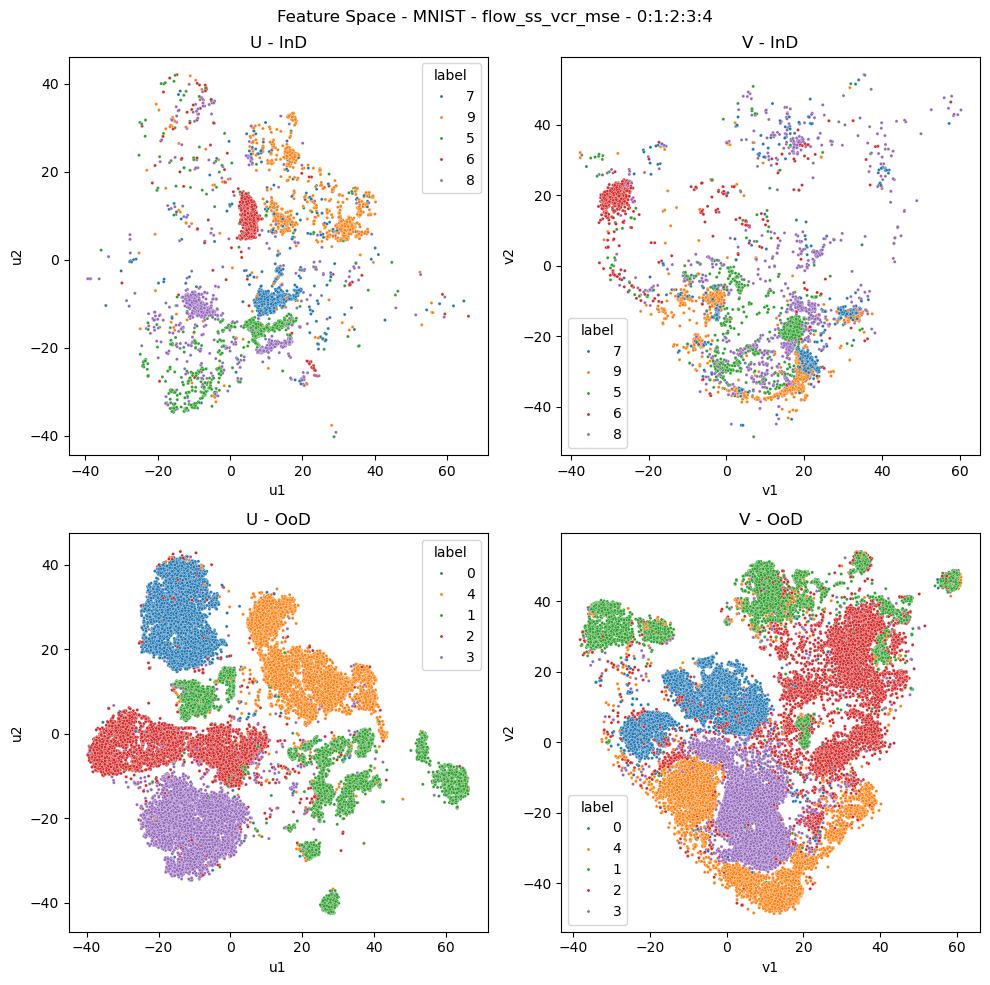

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.04s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.07s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.12s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:02<00:07,  2.55s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:05<00:05,  2.57s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:07<00:02,  2.62s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.67s/it]

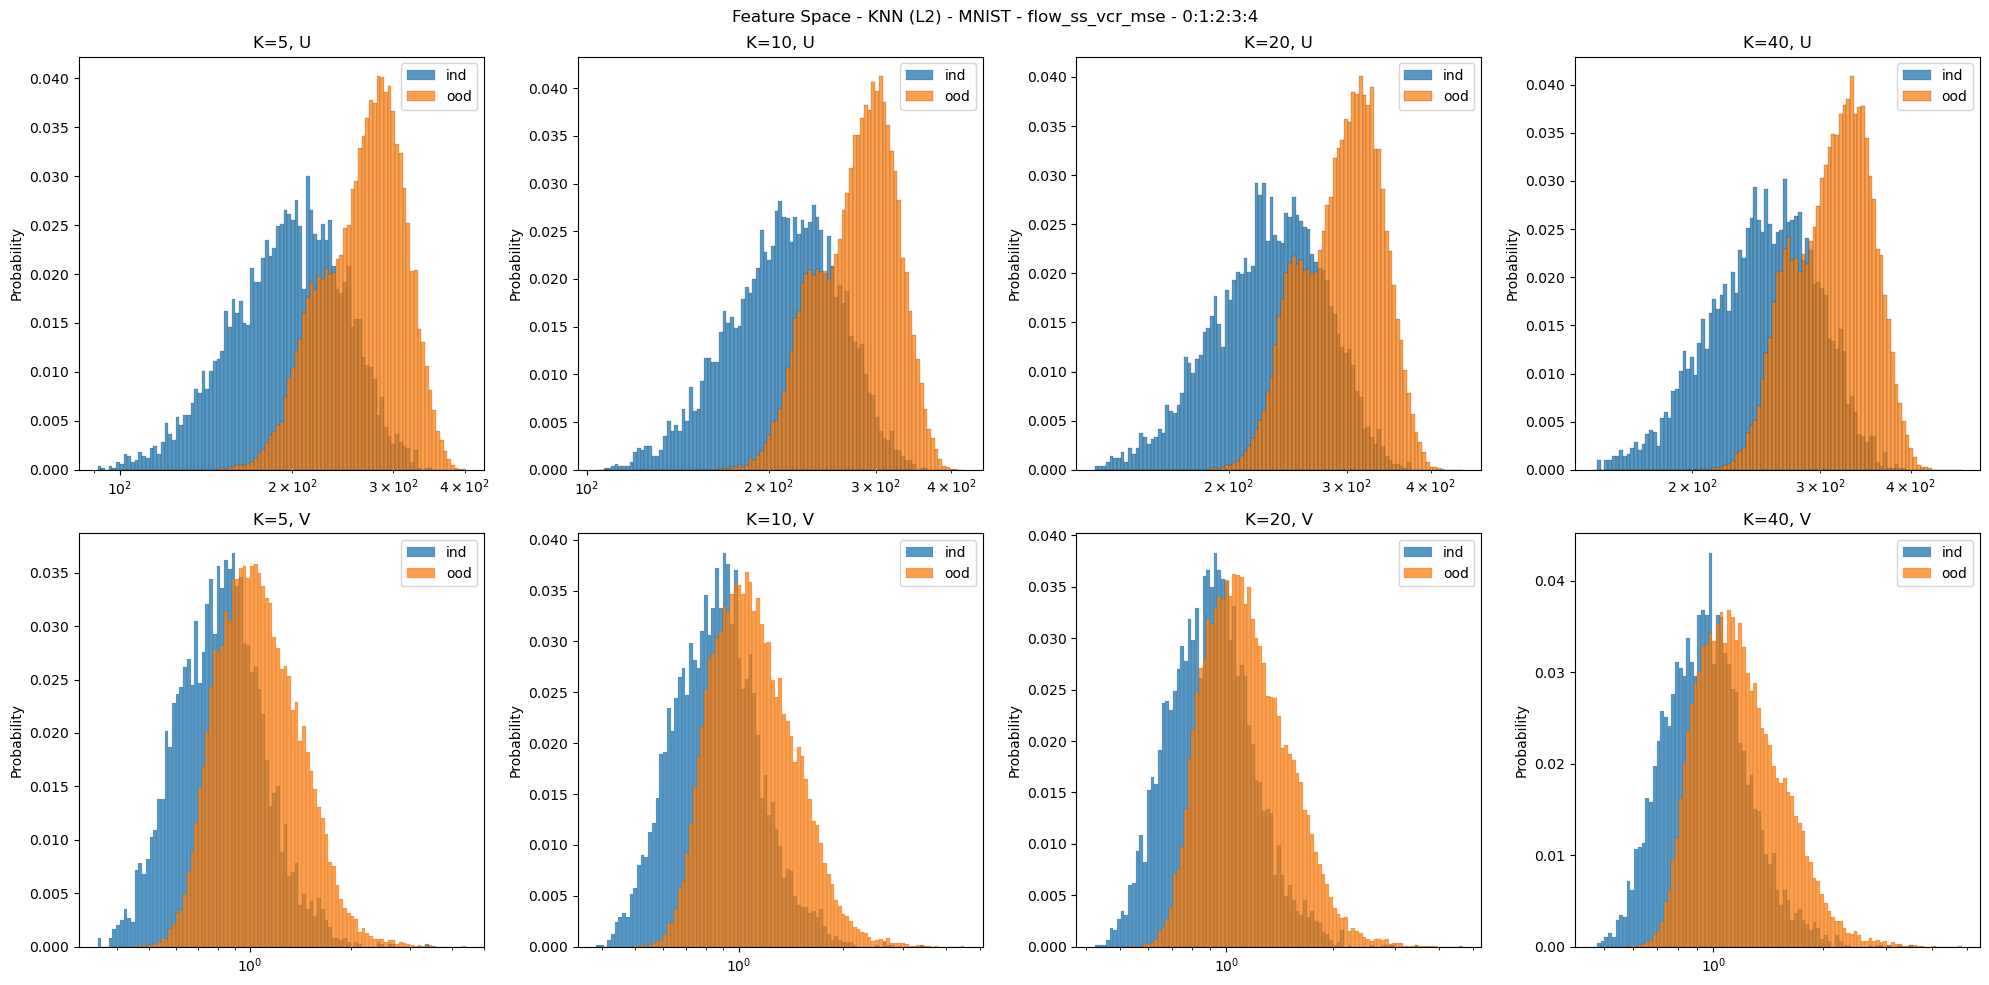

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.01s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.03s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.08s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:02<00:07,  2.51s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:05<00:05,  2.53s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:07<00:02,  2.58s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.77s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.69s/it]

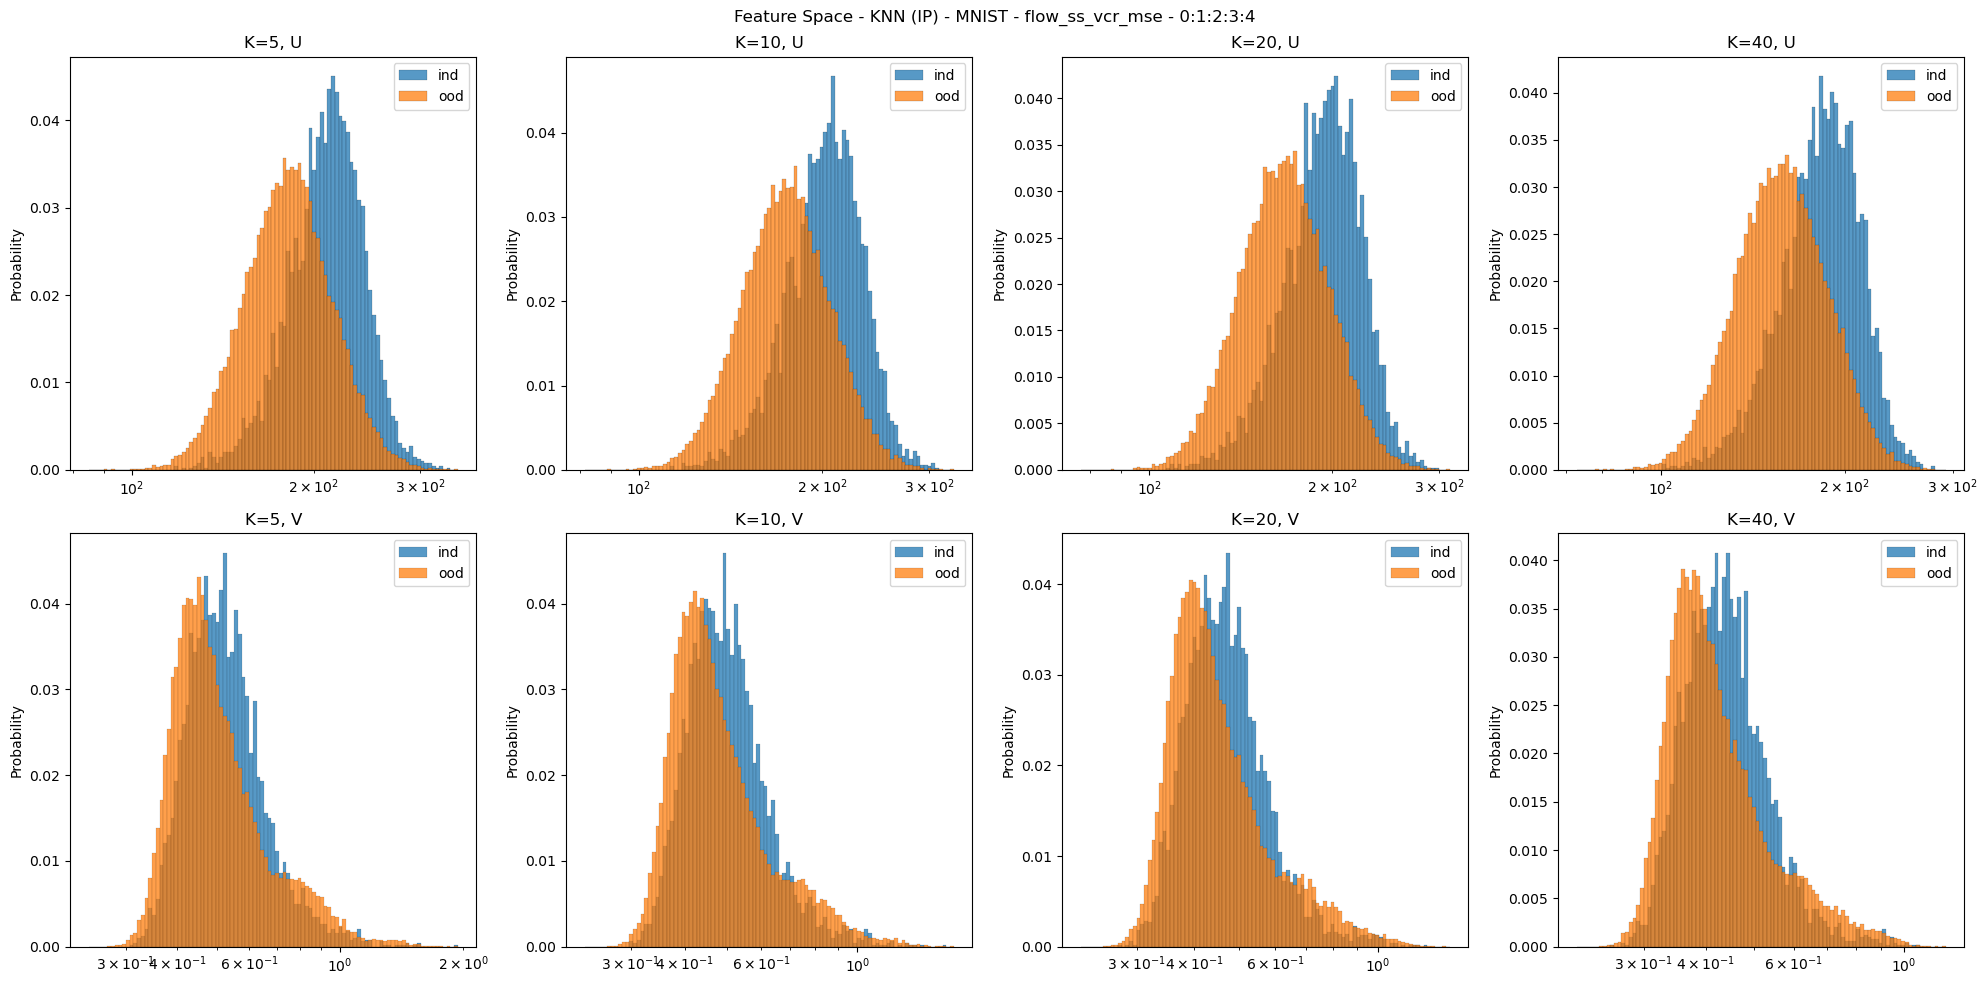

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

17.517294 0.8093688 0.981658 0.13819079
17.475613 0.80093414 0.98295826 0.13830426
17.561352 0.8155576 0.97802615 0.13050039
17.73463 1.031388 1.0530448 0.16768119
25.85908 1.2405053 24.853283 0.742591


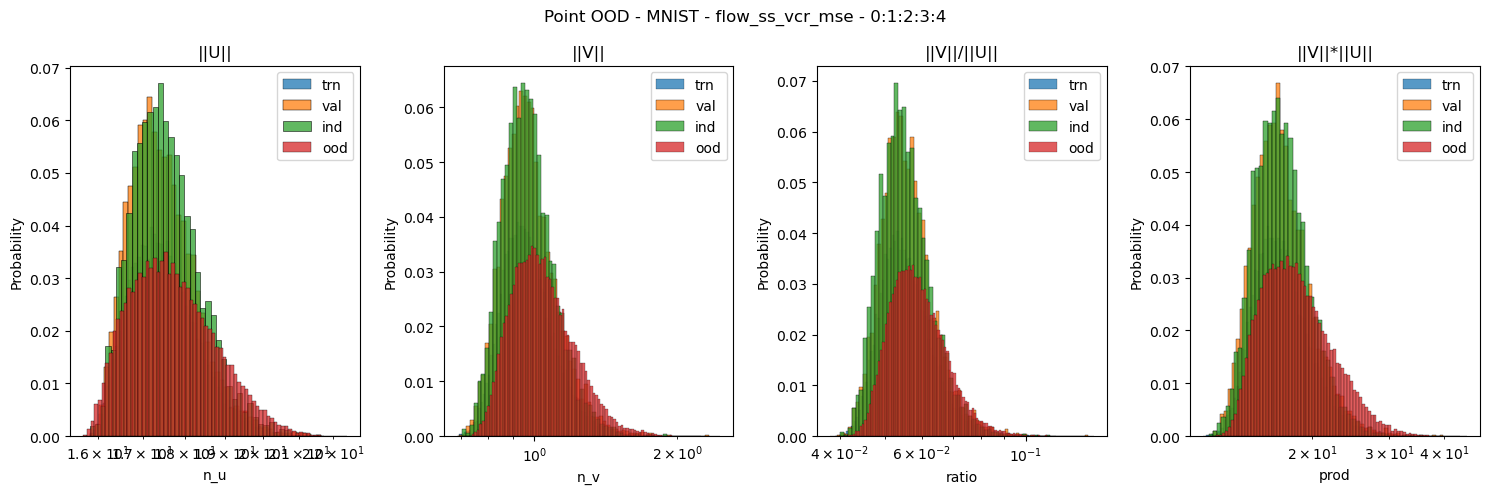

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


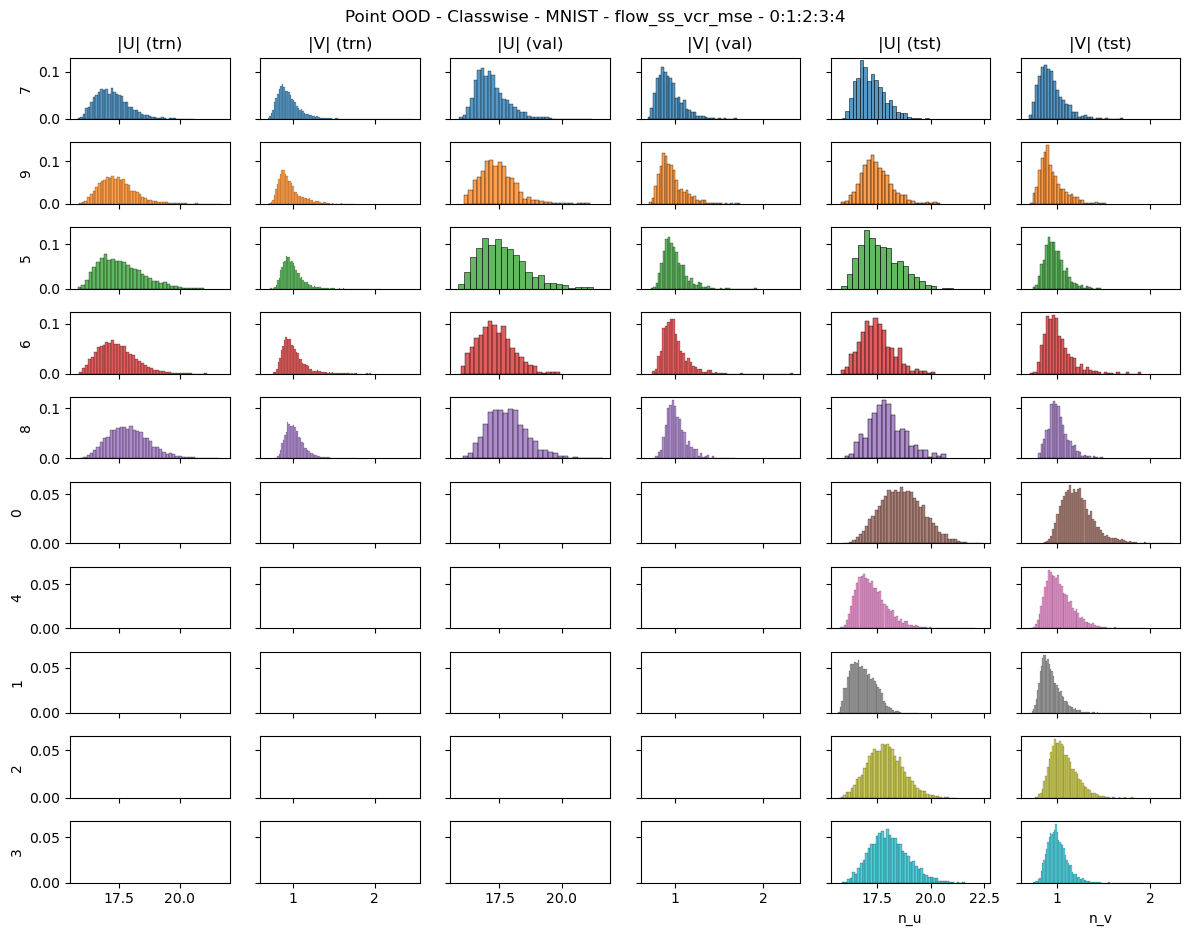

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

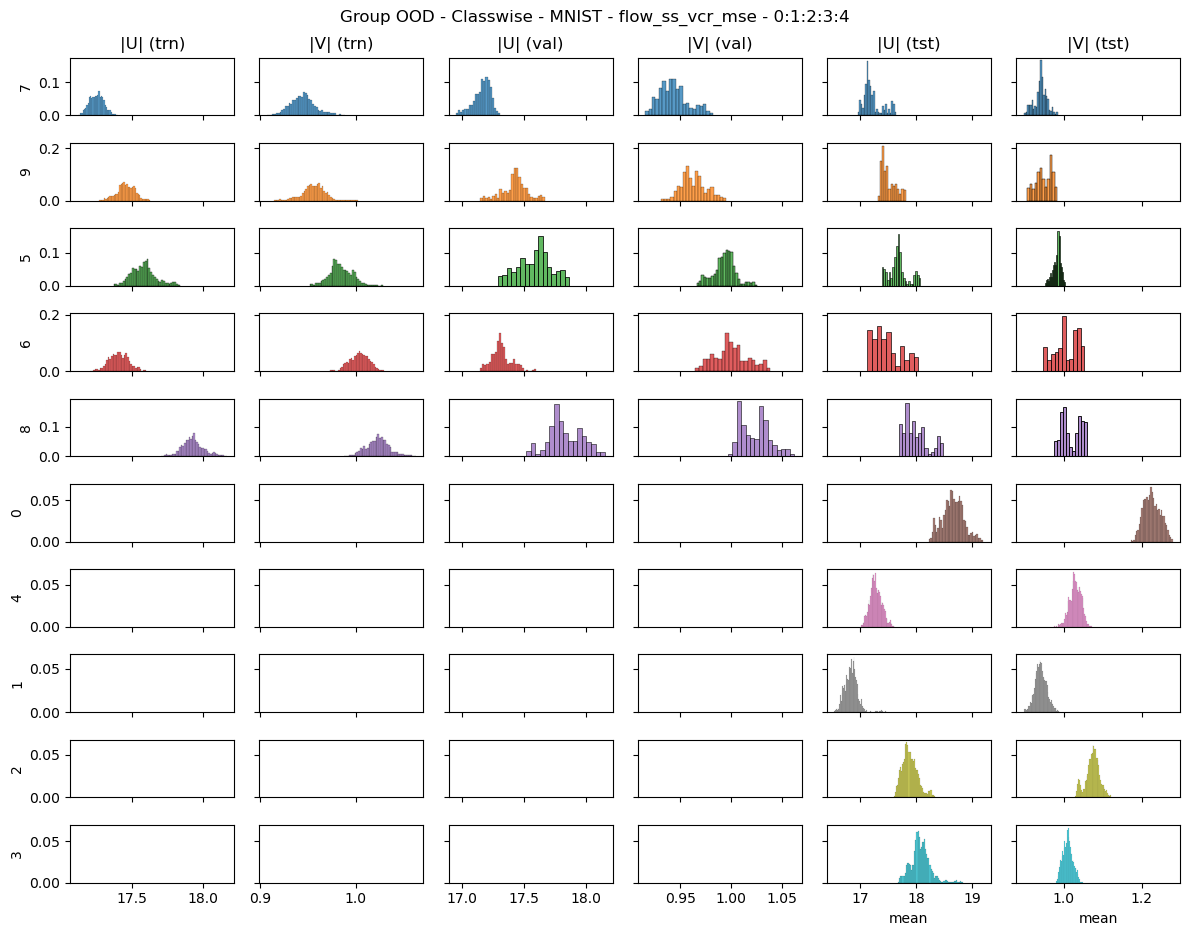

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

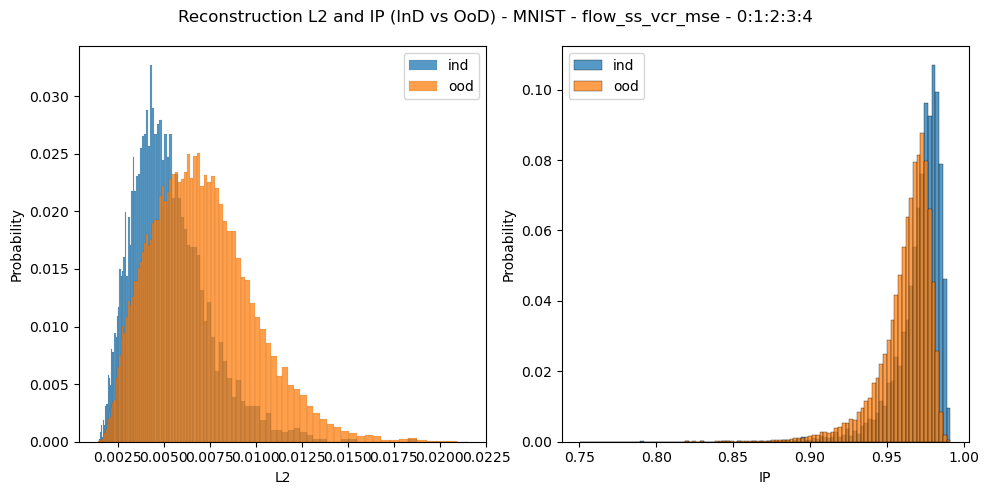

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()